In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns
import gpplot

from model_predictions import deepspcas9_predictions, rule_set2_predictions, crispron_predictions
from datasets import (dataset_list,
                      GuideDataset,
                      human_designs,
                      tracr_list)
from core import (setup_plots,
                  get_model_correlations,
                  get_model_rank_loss,
                  point_range_plot,
                  get_feature_df)

In [2]:
setup_plots()

In [3]:
model = joblib.load('../models/RuleSet3.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [4]:
dataset_activity_list = []
for ds in dataset_list:
    ds.load_data()
    dataset_activity = ds.get_sg_df(include_group=True,
                                    include_activity=True)
    dataset_activity['dataset'] = ds.name
    dataset_activity['genomewide'] = ds.genomewide
    dataset_activity['tracr'] = ds.tracr
    dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2016,True,Hsu2013
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2016,True,Hsu2013
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2016,True,Hsu2013
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2016,True,Hsu2013
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.734196,Aguirre2016,True,Hsu2013
...,...,...,...,...,...,...,...,...
80350,TTTGTTCTTTAAATGGCTAC,CAAATTTGTTCTTTAAATGGCTACAGGAGG,AGG,MED12,-1.951933,Munoz2016,False,Chen2013
80351,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,TGG,PTPN11,-1.693789,Munoz2016,False,Chen2013
80352,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,TGG,RPTOR,-1.234981,Munoz2016,False,Chen2013
80353,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,TGG,SKP2,-0.871017,Munoz2016,False,Chen2013


In [5]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions, 
                         crispron_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.set_sgrnas()
    dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                    how='inner',
                                                    on=['sgRNA Sequence',
                                                        'sgRNA Context Sequence',
                                                        'PAM Sequence'])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df


,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train,CRISPRon,CRISPRon train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2016,True,Hsu2013,25.799622,False,0.489201,False,13.88,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2016,True,Hsu2013,0.784734,False,0.464962,False,3.39,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2016,True,Hsu2013,32.187088,False,0.525786,False,27.21,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.610029,Shalem_2014,True,Hsu2013,32.187088,False,0.525786,False,27.21,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2016,True,Hsu2013,19.478521,False,0.369761,False,14.67,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82582,TTTGTTCATACTTGCAGAGT,GATGTTTGTTCATACTTGCAGAGTTGGACA,TGG,HUWE1,-0.255720,Munoz2016,False,Chen2013,23.622627,False,0.431437,False,27.77,False
82583,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,TGG,PTPN11,-1.693789,Munoz2016,False,Chen2013,23.703417,False,0.442974,False,11.66,False
82584,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,TGG,RPTOR,-1.234981,Munoz2016,False,Chen2013,40.095604,False,0.441318,False,46.54,False
82585,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,TGG,SKP2,-0.871017,Munoz2016,False,Chen2013,14.067232,False,0.456960,False,17.97,False


In [6]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = get_feature_df(dataset_activity_df)
dataset_activity_df['Rule Set 3'] = model.predict(X)
dataset_activity_df['Rule Set 3 train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train,CRISPRon,CRISPRon train,Rule Set 3,Rule Set 3 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2016,True,Hsu2013,25.799622,False,0.489201,False,13.88,False,-1.016797,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2016,True,Hsu2013,0.784734,False,0.464962,False,3.39,False,-1.609001,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2016,True,Hsu2013,32.187088,False,0.525786,False,27.21,False,-0.171504,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.610029,Shalem_2014,True,Hsu2013,32.187088,False,0.525786,False,27.21,False,-0.171504,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2016,True,Hsu2013,19.478521,False,0.369761,False,14.67,False,-0.694439,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82582,TTTGTTCATACTTGCAGAGT,GATGTTTGTTCATACTTGCAGAGTTGGACA,TGG,HUWE1,-0.255720,Munoz2016,False,Chen2013,23.622627,False,0.431437,False,27.77,False,-0.590794,True
82583,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,TGG,PTPN11,-1.693789,Munoz2016,False,Chen2013,23.703417,False,0.442974,False,11.66,False,-1.511311,True
82584,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,TGG,RPTOR,-1.234981,Munoz2016,False,Chen2013,40.095604,False,0.441318,False,46.54,False,-0.507842,True
82585,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,TGG,SKP2,-0.871017,Munoz2016,False,Chen2013,14.067232,False,0.456960,False,17.97,False,-0.947632,True


In [7]:
score_cols = ['Rule Set 3'] + [m.name for m in model_prediction_list]
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                      'PAM Sequence', 'sgRNA Activity',
                                                      'sgRNA Target', 'dataset', 'genomewide'],
                                             value_vars=score_cols,
                                             var_name='model',
                                             value_name='prediction')


In [8]:
cor_performance_ci = get_model_correlations(long_predictions)

100%|██████████| 1000/1000 [02:30<00:00,  6.62it/s]


Saving 4 x 3 in image.
Filename: ../figures/seq_rs3_performance.pdf


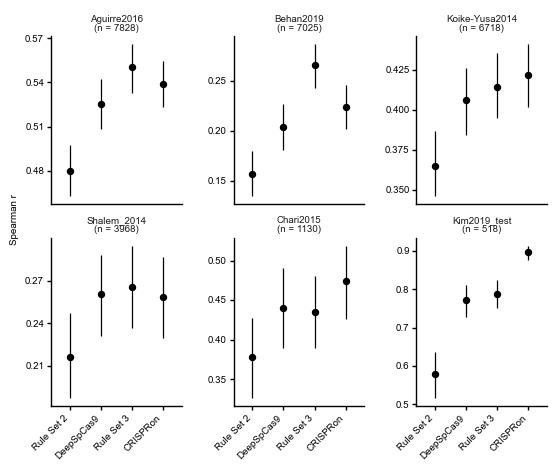

<ggplot: (8778555333955)>

In [18]:
g = point_range_plot(cor_performance_ci, 'model', 'spearman',
                     'spearman_025', 'spearman_975', xlabel='',
                     ylabel='Spearman r', wspace=0.4, facet='dataset_name')
g.save('../figures/seq_rs3_performance.pdf', width=4, height=3)
g

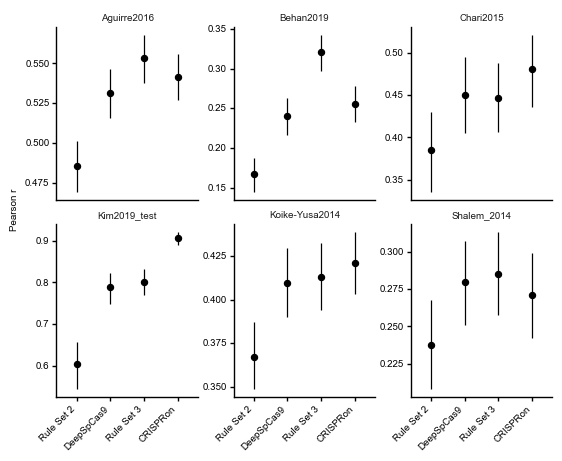

<ggplot: (8778555067109)>

In [10]:
point_range_plot(cor_performance_ci, 'model', 'pearson',
                 'pearson_025', 'pearson_975', xlabel='',
                 ylabel='Pearson r')

In [11]:
genomewide_predictions = long_predictions[long_predictions.genomewide].copy()
rank_loss_performance_ci = get_model_rank_loss(genomewide_predictions)

100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


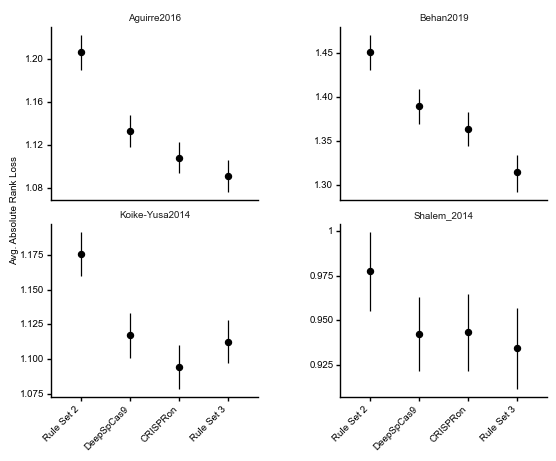

<ggplot: (8778551846054)>

In [12]:
g = point_range_plot(rank_loss_performance_ci, 'model', 'avg_abs_rank_diff',
                     'avg_abs_rank_diff_025', 'avg_abs_rank_diff_975', xlabel='',
                     ylabel='Avg. Absolute Rank Loss', wspace=0.4)
g


### Direct Comparison Between Gecko and Sanger Data with Different tracr predictions

In [23]:
aguire_kwargs = {'filepath':'../data/processed/Aguirre2016_activity.csv',
                 'sgrna_seq_col': 'sgRNA Sequence', 'context_seq_col': 'sgRNA Context Sequence',
                 'rank_col': 'avg_mean_centered_neg_lfc', 'endogenous': True,
                 'name': 'Aguirre2016', 'sgrna_group_col': 'Target Gene Symbol',
                 'cut_perc_col': 'Target Cut %',
                 'design_file': human_designs, 'genomewide': True}

behan_kwargs = {'filepath': '../data/processed/Behan2019_activity.csv',
                'sgrna_seq_col': 'sgRNA Sequence',
                'context_seq_col': 'sgRNA Context Sequence',
                'rank_col': 'avg_mean_centered_neg_lfc',
                'endogenous': True, 'name': 'Behan2019',
                'sgrna_group_col': 'Target Gene Symbol', 'cut_perc_col': 'Target Cut %',
                'design_file': human_designs, 'genomewide': True}

In [24]:
tracr_comparison_data = []
tracr_options = tracr_list
for tracr in tracr_options:
    aguire_tracr_kwargs = aguire_kwargs.copy()
    aguire_tracr_kwargs['tracr'] = tracr
    tracr_comparison_data.append(GuideDataset(**aguire_tracr_kwargs))
    behan_tracr_kwargs = behan_kwargs.copy()
    behan_tracr_kwargs['tracr'] = tracr
    tracr_comparison_data.append(GuideDataset(**behan_tracr_kwargs))

In [28]:
tracr_comparison_activity_list = []
for ds in tracr_comparison_data:
    ds.load_data()
    dataset_activity = ds.get_sg_df(include_group=True,
                                    include_activity=True)
    dataset_activity['dataset'] = ds.name
    dataset_activity['genomewide'] = ds.genomewide
    dataset_activity['tracr'] = ds.tracr
    tracr_comparison_activity_list.append(dataset_activity)
tracr_comparison_activity_df = (pd.concat(tracr_comparison_activity_list)
                                .reset_index(drop=True))
sgrna_count = tracr_comparison_activity_df['sgRNA Sequence'].value_counts()
overlapping_sgrnas = sgrna_count.index[sgrna_count == 4]
tracr_comparison_activity_df = (tracr_comparison_activity_df[
    tracr_comparison_activity_df['sgRNA Sequence'].isin(overlapping_sgrnas)]
                                .reset_index(drop=True))
tracr_comparison_activity_df['dataset_name'] = tracr_comparison_activity_df['dataset'].replace(
    {'Aguirre2016': 'Aguirre2016 sgRNAs\n(Hsu 2013 tracr)',
     'Behan2019': 'Behan2019 sgRNAs\n(Chen 2013 tracr)'})
tracr_comparison_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr,dataset_name
0,AAAACTGGCACGACCATCGC,CCGGAAAACTGGCACGACCATCGCTGGGGT,TGG,PSMB7,-1.052943,Aguirre2016,True,Hsu2013,Aguirre2016 sgRNAs\n(Hsu 2013 tracr)
1,AAAAGAAAACATTCGTCTTT,GGAAAAAAGAAAACATTCGTCTTTTGGGAG,TGG,PET117,-1.112743,Aguirre2016,True,Hsu2013,Aguirre2016 sgRNAs\n(Hsu 2013 tracr)
2,AAAAGATTTGCGCACCCAAG,TAGAAAAAGATTTGCGCACCCAAGTGGAAT,TGG,PRC1,0.028674,Aguirre2016,True,Hsu2013,Aguirre2016 sgRNAs\n(Hsu 2013 tracr)
3,AAAAGTCCAAGCATAGCAAC,CGGGAAAAGTCCAAGCATAGCAACAGGTAA,AGG,TOP1,0.195309,Aguirre2016,True,Hsu2013,Aguirre2016 sgRNAs\n(Hsu 2013 tracr)
4,AAACACAAAATTCACGTCCA,GAATAAACACAAAATTCACGTCCAAGGAAC,AGG,DDX52,-0.358209,Aguirre2016,True,Hsu2013,Aguirre2016 sgRNAs\n(Hsu 2013 tracr)
...,...,...,...,...,...,...,...,...,...
3499,TTTGCTGTCCCGCCTGTACA,GGCGTTTGCTGTCCCGCCTGTACATGGGCA,TGG,NXT1,-0.239636,Behan2019,True,Chen2013,Behan2019 sgRNAs\n(Chen 2013 tracr)
3500,TTTGGTAGCTCAACAACTCG,TGTTTTTGGTAGCTCAACAACTCGAGGATG,AGG,LIN7C,-0.040167,Behan2019,True,Chen2013,Behan2019 sgRNAs\n(Chen 2013 tracr)
3501,TTTGTCTGATGACTACTCAA,AAATTTTGTCTGATGACTACTCAAAGGTAT,AGG,NOL10,0.351555,Behan2019,True,Chen2013,Behan2019 sgRNAs\n(Chen 2013 tracr)
3502,TTTGTGGCAGCGAATCATAA,TGTCTTTGTGGCAGCGAATCATAATGGTTC,TGG,UMPS,-0.040691,Behan2019,True,Chen2013,Behan2019 sgRNAs\n(Chen 2013 tracr)


In [29]:
tracr_comparison_X = get_feature_df(tracr_comparison_activity_df)
tracr_comparison_activity_df['Rule Set 3'] = model.predict(tracr_comparison_X)

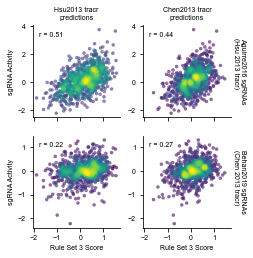

In [39]:
g = sns.FacetGrid(data=tracr_comparison_activity_df, col='tracr', row='dataset_name', margin_titles=True,
                  height=1.7, sharey=False)
g.map_dataframe(gpplot.point_densityplot, x='Rule Set 3', y='sgRNA Activity',
                s=10)
g.map_dataframe(gpplot.add_correlation, x='Rule Set 3', y='sgRNA Activity',
                color='black', method='spearman')
g.set_titles(col_template="{col_name} tracr\npredictions", row_template="{row_name}")
g.set_axis_labels(x_var='Rule Set 3 Score', y_var='sgRNA Activity')
plt.subplots_adjust(hspace=0.2)
gpplot.savefig('../figures/aguirre_behan_tracr_rs3_performance.pdf', dpi=300)